<a href="https://colab.research.google.com/github/databyhuseyn/NLP/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
  return 3 * x ** 2 - 4 * x + 5

In [3]:
f(3.0)

20.0

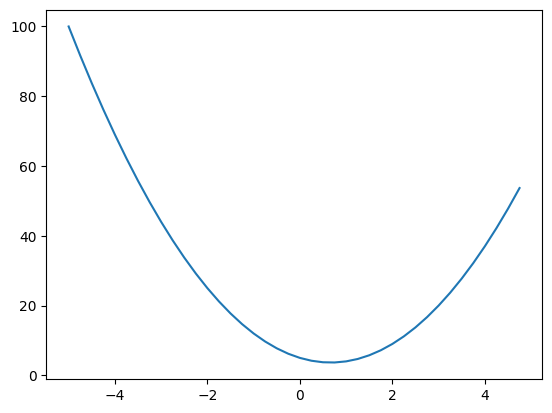

In [11]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys);

$\frac{f(w1 + h) × x1}{h}$


$\frac{w1x1 + hx1 - w1x1}{h}$


$\frac{hx1}{h} = x1$


In [ ]:
h = 0.001
x = 3.0
print(f(h + x))
print(f(h + x) - f(x))
print((f(h + x) - f(x)) / h)

20.014003000000002
0.01400300000000243
14.00300000000243


In [ ]:
# More complex examples
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

a += h
d2 = a*b + c
print(f'{d1=}; {d2=}')
print('slope: ', ((d2 - d1)/h))

d1=4.0; d2=3.997
slope:  -3.0000000000001137


In [ ]:
h = 0.001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c

b += h
d2 = a*b + c
print(f'{d1=}; {d2=}')
print('slope: ', ((d2 - d1) / h))

d1=4.0; d2=4.002
slope:  1.9999999999997797


In [ ]:
class Value:
  def __init__(self, data, _children = (), _op = '', label = ''):
    self.data = data
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0.0

  def __repr__(self):
    return f'Value(data = {self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad = other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __exp__(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def __rmul__(self, other):
    return self * other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad   # derivative of exponential is exponential
    out._backward = _backward

    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()





a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L


Value(data = -8.0)

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
L.backward()

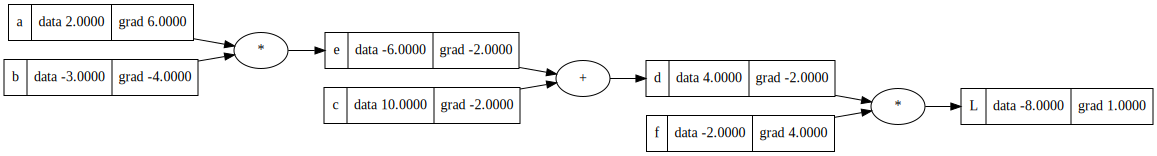

In [ ]:
draw_dot(L)

Evidence for multiplication:

$\frac{f((d + h) * c) - f(d * c)} {h}$

$\frac{(cd + ch - cd)}{h}$

$\frac{ch}{h} = c $

Evidence for adding:

$\frac{f((d + h) + c) - f(d + c)}{h}$

$\frac{(d + h + c - d - c)}{h}$

$\frac{h}{h} = 1$

Chain rule:

$\frac{dL}{dd}$ $\times$ $\frac{dd}{de}$ = $\frac{dL}{de}$

In [ ]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
e.grad = -2.0 * 1 # dL/dd * dd/de
c.grad = -2.0
a.grad = -2.0 * 1 * -3.0 # dL/dd * dd/de * de/da
b.grad = -2.0 * 1 * 2.0 # dL/dd * dd/de * de/db


In [ ]:
a.data += 0.01 * a.grad     # 0.01 as a learning rate
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-7.4352


In [ ]:
def lol():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  a.data += h
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label='L'
  L2 = L.data

  print(((L2-L1) / h))

lol()

6.000000000000227


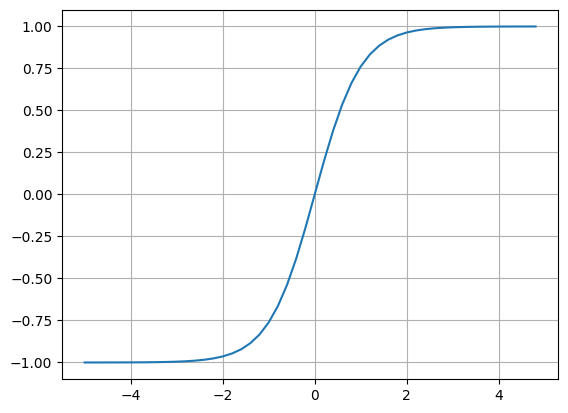

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()  # it automates finding derivative gradient

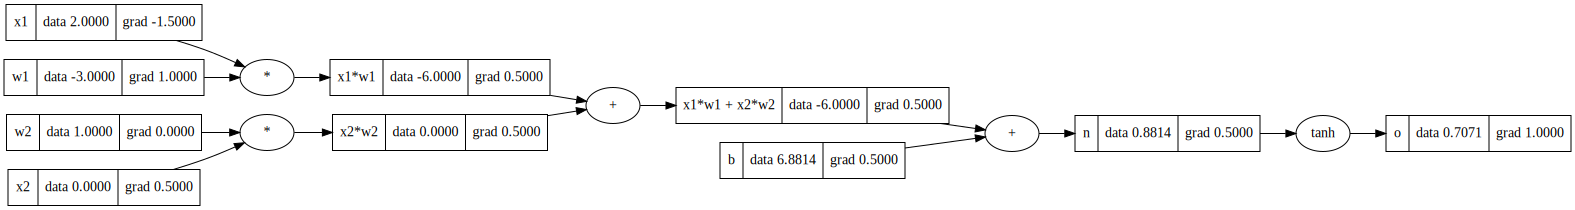

In [ ]:
draw_dot(o)

Unautomated derivative

In [ ]:
o.grad = 1.0
n.grad = 1.0 - 0.7071 ** 2   # (1-tanh)^2    |   0.7071 is tanh's output
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

Automated derivative

In [ ]:
o.grad = 1    #

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()

In [ ]:
x2w2._backward()

topological sort - which enables us to sort graphs in order to automate finding derivatives

In [ ]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)


for node in reversed(topo):
    node._backward()

rewriting tanh function from scratch in atomic level

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                 ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                 ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]           # creates weights with # of inputs
    self.b = Value(random.uniform(-1, 1))                                 # creates bias

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)               # sums each weights with inputs and biases
    out = act.tanh()                                                      # uses activation function
    return out

  def parameters(self):
    return self.w + [self.b]                                              # returns parameters


class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]                     # nin # of features, nout # of neurons

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]                                   # get neurons predictions
    return outs[0] if len(outs) == 1 else outs                            # if it has 1 value, extract from list

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]    # returns parameters

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts                                                    # we combined inputs and outputs
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]      # we use this as a sliding windows

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])                                                     # 3 inputs, 1st layer 4 neurons, 2nd layer 4 neurons, 1 neuron
n(x)

Value(data = -0.8933499993248868)

In [ ]:
X = [2.0, 1.0]
n = Neuron(len(X))
n(X)

Value(data = 0.8974645704250214)

In [ ]:
X = [2.0, 1.0]
n = Layer(2, 3)
outputs = n(X)
outputs

[Value(data = -0.9282075926984314),
 Value(data = 0.07815441060390692),
 Value(data = -0.30539962571227525)]

In [ ]:
mlp = MLP(2, [4, 4, 1])
outs = mlp(x)

In [ ]:
outs.backward()

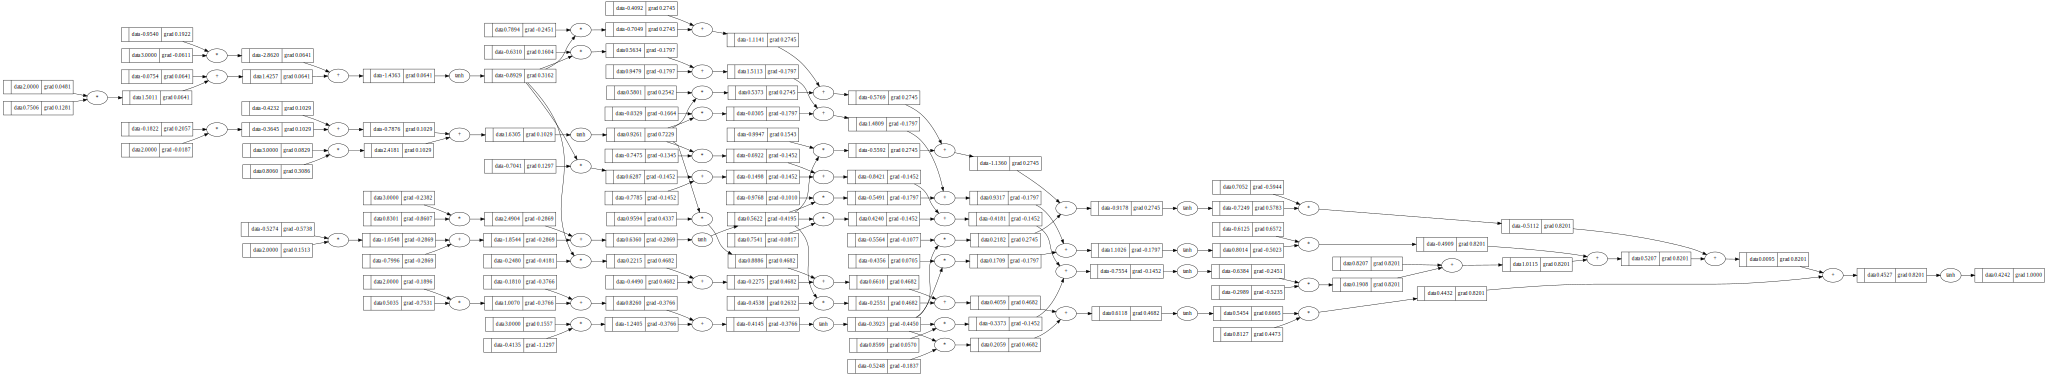

In [ ]:
draw_dot(outs)

In [ ]:
1280 * 720 * 3

2764800

In [ ]:
X = [10, 15, 26, 32, 89]

mlp = MLP(len(X), [10, 10, 1])
new_outs = mlp(X)

In [ ]:
new_outs.backward()

In [ ]:
from sklearn.tree import export_graphviz


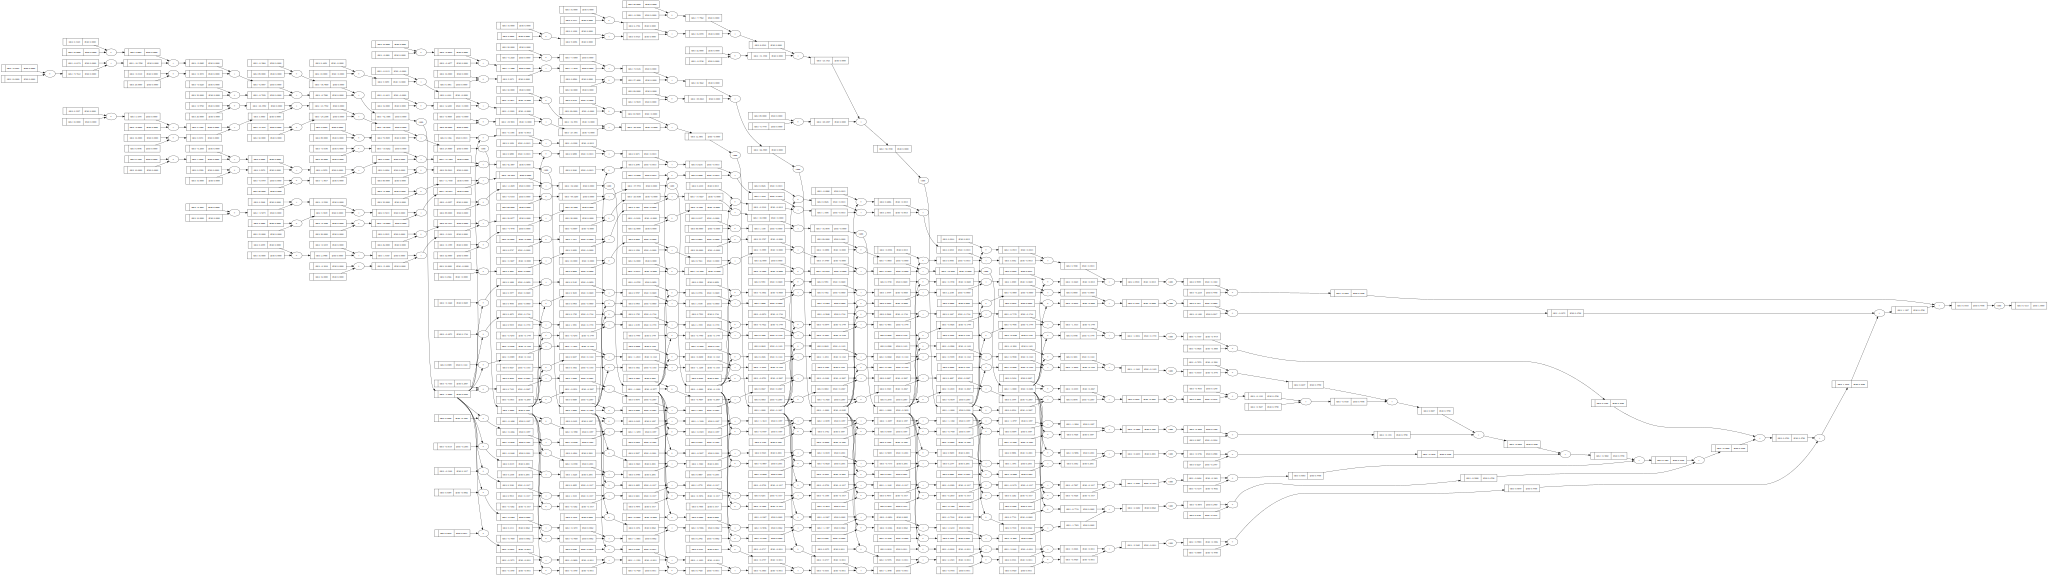

In [ ]:
t = draw_dot(new_outs)
t

In [ ]:
t.render(filename='mlp_graph', format='svg', cleanup=True)

'mlp_graph.svg'

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data = -0.9978147261428039),
 Value(data = 0.2881709210819235),
 Value(data = -0.9439419884632533),
 Value(data = -0.9377232285531869)]

In [ ]:
loss = [((yout - ygt)**2).data for ygt, yout in zip(ys, ypred)]
sum(loss)

9.408561813046138

In [ ]:
loss = sum(((yout-ygt) ** 2 for ygt, yout in zip(ys, ypred)))
loss.backward()

In [ ]:
for p in n.parameters():
  p.grad == 0

In [ ]:
for k in range(100000):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(((yout-ygt)**2 for ygt, yout in zip(ys, ypred)))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
95000 0.0006134249890538189
95001 0.0006134193482185734
95002 0.0006134137074866431
95003 0.000613408066858018
95004 0.0006134024263327086
95005 0.000613396785910706
95006 0.0006133911455920029
95007 0.0006133855053766137
95008 0.0006133798652645025
95009 0.0006133742252557057
95010 0.0006133685853501902
95011 0.0006133629455479714
95012 0.0006133573058490358
95013 0.0006133516662533835
95014 0.0006133460267610106
95015 0.000613340387371915
95016 0.0006133347480861034
95017 0.0006133291089035493
95018 0.000613323469824278
95019 0.0006133178308482686
95020 0.0006133121919755246
95021 0.0006133065532060456
95022 0.000613300914539816
95023 0.0006132952759768515
95024 0.0006132896375171346
95025 0.0006132839991606642
95026 0.0006132783609074466
95027 0.0006132727227574709
95028 0.000613267084710741
95029 0.000613261446767246
95030 0.0006132558089269931
95031 0.0006132501711899639
95032 0.0006132445335561711
95033 0.00061323

In [ ]:
ypred

[Value(data = 1.0),
 Value(data = -0.9939900468245155),
 Value(data = -0.9832853115784123),
 Value(data = 0.983539125112233)]